# Demo 10 - Testing and Evaluating Models

In this notebook we explore how to evaluate regression models and perform cross-validation.

In [1]:
# clone the course repository, change to right directory, and import libraries.
%cd /content
!git clone https://github.com/nmattei/cmps3160.git
%cd /content/cmps3160/_demos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
plt.style.use('fivethirtyeight')
# Make the fonts a little bigger in our graphs.
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['pdf.fonttype'] = 42

/content
Cloning into 'cmps3160'...
remote: Enumerating objects: 1647, done.
remote: Counting objects: 100% (537/537), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 1647 (delta 319), reused 445 (delta 261), pack-reused 1110
Receiving objects: 100% (1647/1647), 45.27 MiB | 7.40 MiB/s, done.
Resolving deltas: 100% (920/920), done.
/content/cmps3160/_demos


## Loading and Understanding the Data

For this work we will use the same data from the previous demo: ["Generalized body composition prediction equation for men using simple measurement techniques"](http://staff.pubhealth.ku.dk/~tag/Teaching/share/data/Bodyfat.html)


,Age,Neck,Forearm,Wrist,bodyfat
0,-1.740073,-0.738665,-0.626718,-1.212541,-0.820246
1,-1.819583,0.209365,0.117079,-0.031943,-1.562573
2,-1.819583,-1.645475,-1.717621,-1.749177,0.736245
3,-1.501543,-0.244041,0.365012,-0.031943,-1.047733
4,-1.660563,-1.480601,-0.477959,-0.568578,1.143327


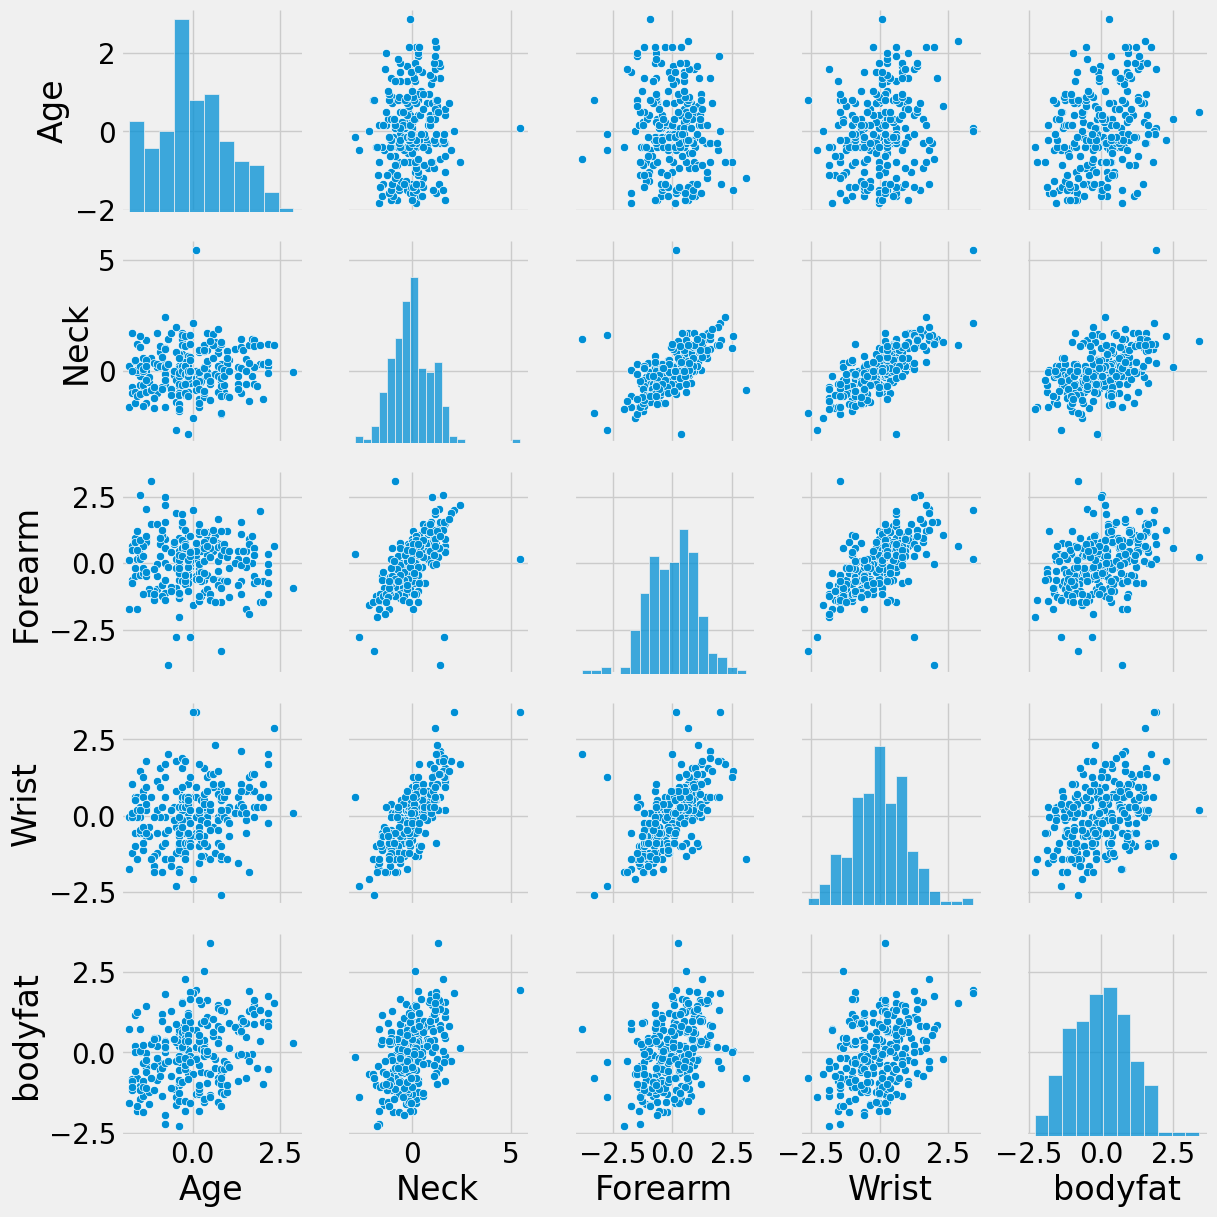

In [3]:
# Load the Penrose Data
# Select a subste of columns
# Z-score all columns
# Make pairplot
input_names = ['Age', 'Neck', 'Forearm', 'Wrist']
output_name = 'bodyfat'
df = pd.read_csv("./data/bodyfat.csv")[input_names + [output_name]].apply(stats.zscore)
sns.pairplot(df)
df.head()

## Linear Regression
Scikit-learn implements [Linear Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) as well.

All regression/classification classes in scikit-learn assume two functions:

- `.fit(X, y)`: fit/train the model giving training data `X` (the feature matrix) and `y` (the true values)
- `.predict(X)`: given a feature matrix, return the predicted `y` values.

In [4]:
# Let's set the X and y variables.
X = df[input_names]
y = df[output_name]
display(X.head())
display(y.head())

,Age,Neck,Forearm,Wrist
0,-1.740073,-0.738665,-0.626718,-1.212541
1,-1.819583,0.209365,0.117079,-0.031943
2,-1.819583,-1.645475,-1.717621,-1.749177
3,-1.501543,-0.244041,0.365012,-0.031943
4,-1.660563,-1.480601,-0.477959,-0.568578


0   -0.820246
1   -1.562573
2    0.736245
3   -1.047733
4    1.143327
Name: bodyfat, dtype: float64

In [9]:
from sklearn.linear_model import LinearRegression
# Create a new regression model
lr = LinearRegression()
# fit the model on all data
lr.fit(X,y)
# predict on all data
y_predicted = lr.predict(X)

## Mean Average Error

How good is this model? To start, let's use Mean Average Error for evaluation:

$$MAE = \frac{1}{n}\sum_i^n |y - y_{\text{predicted}}|$$

In [10]:
def mae(y, y_predicted):
  return (y - y_predicted).abs().mean()

mae(y, y_predicted)

0.6646261129445074

### Interpreting MAE

Since we have already z-scored the $y$ variables, MAE$=1$ means that, on average, our prediction is one standard-deviation from the truth. That would not be very good for most applications.

We can also make a scatter plot comparing the true values with predicted values.

**Question:** What does the set of "perfect predictions" look like on this graph?

**Question:** What type of error is this? What did we do "wrong" from last lecture?

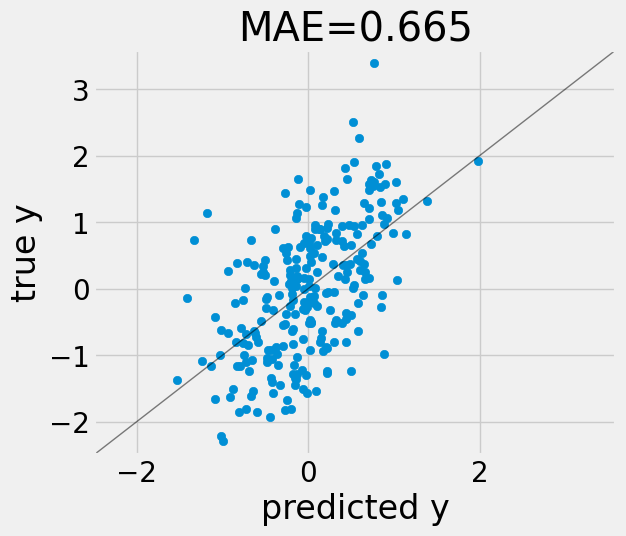

In [11]:
# plot truth vs predicted
def plot_predictions(y, y_predicted):
  plt.figure(figsize=(6,5))
  plt.scatter(y_predicted, y)
  plt.xlabel('predicted y')
  plt.ylabel('true y')
  plt.title('MAE=%.3f' % mae(y, y_predicted))
  # make x/y ranges the same
  min_val = min(min(y), min(y_predicted))-.2
  max_val = max(max(y), max(y_predicted))+.2
  plt.xlim(min_val, max_val)
  plt.ylim(min_val, max_val)
  # plot line for "perfect predictions"
  plt.plot([min_val, max_val], [min_val, max_val], 'k-', lw=1, alpha=.5)
  plt.show()

plot_predictions(y, y_predicted)

## Train/Test Splits

The MAE above is calculated on the training data. As we discussed, for prediction purposes, we don't really care much about the error on the training data. Instead, we care what the expected error will be on **new, unseen** data. This is what we call **generalization error**.

Splitting the data into a train and test set is a simple way to simulate what our error would be on a new, unseen sample of data.

Below, we'll split our data randomly into equal-sized train/test sets, then calculate error.

In [12]:
def split_data(X, y, training_fraction=.5):
  # sample the training and testing indices
  # setting random_state fixes the seed of the random number generator so we
  # get the same split each time (otherwise it can be very hard to reproduce/debug results!)
  train_idx = X.sample(frac=training_fraction, random_state=42).index
  test_idx = X.index[~X.index.isin(train_idx)]
  return (X.iloc[train_idx], y.iloc[train_idx], X.iloc[test_idx], y.iloc[test_idx])

X_train, y_train, X_test, y_test = split_data(X, y, training_fraction=0.5)
print('%d training and %d testing samples' % (len(X_train), len(X_test)))
print('first training instance: ')
display(X_train.head(1)) # this will change if I change random_state

126 training and 126 testing samples
first training instance: 


,Age,Neck,Forearm,Wrist
165,-0.785952,1.033738,2.497231,1.255983


### Test error

Now, we can train on the training data and test on the testing data.

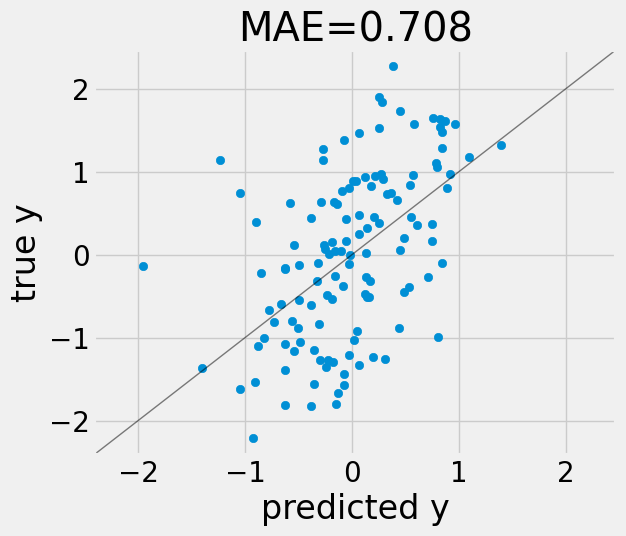

In [13]:
lr.fit(X_train,y_train)
y_predicted = lr.predict(X_test)
plot_predictions(y_test, y_predicted)

**Question: How does this error compare to the training error above?**

**Question:** This only gives us one measure of error? What if we got lucky or unlucky? How could we get more data for testing?



## Cross-validation
But, this is just one split of the data. Maybe we got lucky/unlucky?

If we really care about estimating generalization error, we can repeat this splitting process many times to get a more robust and reliable estimate. The process we use is **cross-validation**.

![](https://github.com/nmattei/cmps3160/blob/master/_labs/images/k-folds.png?raw=1)


We implement cross-validation ourselves below, but you can also just use the [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=kfold#sklearn.model_selection.KFold) implementation in sklearn.

In [14]:
def cross_validation(X, y, n_folds=5):
  """
  Return an iterator over (training index, testing index) pairs
  for each cross-validation fold.
  """
  # test size -- we might lose a few at the end here if there is a remainder.
  test_size = int(len(y)/n_folds)
  # all possible indices
  all_idx = set(np.arange(len(y)))
  for i in range(n_folds):
    # slides the test window forward
    test_idx = np.arange(i*test_size, i*test_size+test_size)
    # use the rest as training indices.
    train_idx = np.array(list(all_idx - set(test_idx)))
    # yield vs return: this makes the method Iterable
    yield (train_idx, test_idx)

# let's test on a simple example of 5-fold cross validation on 10 instances
X_small = X.head(10)  # what happens if we use 11 instances?
y_small = y.head(10)
# because we use yield, we can iterate over the output
# of the cross-validation function.
for train_idx, test_idx in cross_validation(X_small, y_small):
  print('train_idx=%s  test_idx=%s' % ((train_idx, test_idx)))

train_idx=[2 3 4 5 6 7 8 9]  test_idx=[0 1]
train_idx=[0 1 4 5 6 7 8 9]  test_idx=[2 3]
train_idx=[0 1 2 3 6 7 8 9]  test_idx=[4 5]
train_idx=[0 1 2 3 4 5 8 9]  test_idx=[6 7]
train_idx=[0 1 2 3 4 5 6 7]  test_idx=[8 9]


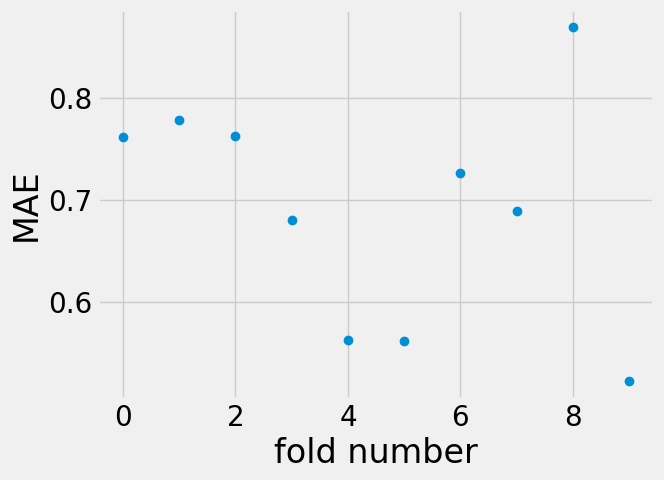

[0.7616779791196403,
 0.77813382181349,
 0.7628497414297044,
 0.6797802458496447,
 0.5619278817121663,
 0.5610028900059079,
 0.7269564387827668,
 0.6891785523857835,
 0.8696595872122699,
 0.5219594696331968]

mean MAE=0.691, std=0.106


In [15]:
# Now, let's compute the MAE for 10 folds of cross-validation on the full dataset.
maes = []
for train_idx, test_idx in cross_validation(X, y, n_folds=10):
  lr.fit(X.iloc[train_idx], y.iloc[train_idx])
  maes.append(mae(y.iloc[test_idx], lr.predict(X.iloc[test_idx])))

plt.figure()
plt.plot(maes, 'o')
plt.xlabel('fold number')
plt.ylabel('MAE')
plt.show()

display(maes)
print('mean MAE=%.3f, std=%.3f' % (np.mean(maes), np.std(maes)))

That's a lot of variation!!

This is not too surprising. Since we have less than 300 examples, changing the training set by 30 instances in each fold is more than a 10% change. Thus, we get very different models and very different test errors.

## Baselines

So, how do we know if the MAE above is any good? To put such numbers in context, it is often helpful to have a simple baseline to compare to. What is a simple baseline for this task?

<br><br><br><br>

Well, we could just return a random number sampled uniformly from the range of $y$ values seen in the training set.

Is there something slightly better that is also easy?

In [16]:
# First, let's make a function to compute the mean error and stddev
def cv_error(X, y, model):
  maes = []
  for train_idx, test_idx in cross_validation(X, y, n_folds=10):
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    maes.append(mae(y.iloc[test_idx], model.predict(X.iloc[test_idx])))
  return np.mean(maes), np.std(maes)

lr_mae, lr_std = cv_error(X, y, lr)
print('linear regression: mae=%.3f std=%.3f' % (lr_mae, lr_std))

linear regression: mae=0.691 std=0.106


In [17]:
class RandomBaseline:
  """
  A random regression baseline that just returns a number
  selected uniformly within the range of the max/min values
  seen in the training data.
  """
  def __init__(self):
    # set our seed for reproducibility
    np.random.seed(42)

  def fit(self, X, y):
    self.min_y = min(y)
    self.max_y = max(y)

  def predict(self, X):
    return np.random.uniform(self.min_y, self.max_y, len(X))

rb = RandomBaseline()
rb.fit(X.head(), y.head())
rb.predict(X.head())

array([-0.54910458,  1.00996518,  0.41812974,  0.05733731, -1.14040186])

In [18]:
class MeanBaseLine:
  """
  A slightly better baseline that returns the mean of the training set
  """
  def __init__(self):
    pass

  def fit(self, X, y):
    self.mean = np.mean(y)

  def predict(self, X):
    return [self.mean]*len(X)

me = MeanBaseLine()
me.fit(X.head(), y.head())
me.predict(X.head())

[-0.31019595973030123,
 -0.31019595973030123,
 -0.31019595973030123,
 -0.31019595973030123,
 -0.31019595973030123]

In [19]:
rb_mae, rb_std = cv_error(X, y, RandomBaseline())
me_mae, me_std = cv_error(X, y, MeanBaseLine())
print('random baseline: mae=%.3f std=%.3f' % (rb_mae, rb_std))
print('mean baseline: mae=%.3f std=%.3f' % (me_mae, me_std))

random baseline: mae=1.664 std=0.285
mean baseline: mae=0.821 std=0.248


**Whew, at least we're doing better than random**

Let's make a convenience function to plot the errors for a list of models.

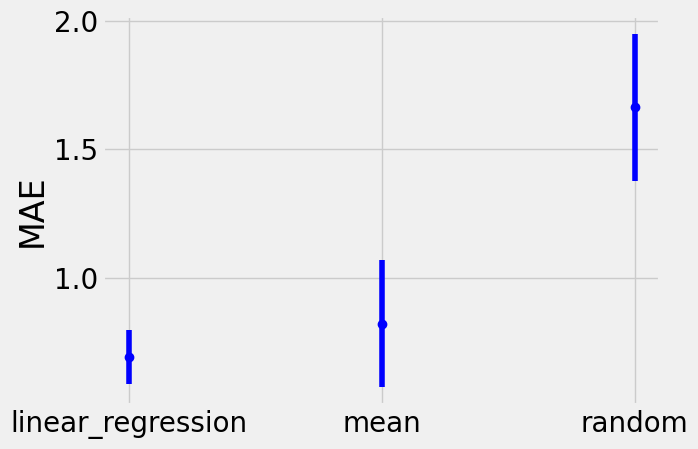

In [20]:
def compare_errors(errs, stds, labels):
  plt.figure()
  xs = np.arange(len(errs))
  plt.errorbar(xs, errs, fmt='bo', yerr=stds)
  plt.xticks(xs, labels)
  plt.ylabel('MAE')
  plt.show()
compare_errors([lr_mae, me_mae, rb_mae], [lr_std, me_std, rb_std], ['linear_regression', 'mean', 'random'])

## Polynomial Regression

To implement polynomial regression, we'll simply add new feature columns corresponding to higher-order transformations of the input features.

We'll implement this ourselves, though
sklearn also has a class for this: [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomial)

In [21]:
def make_polynomial(X, order=2):
  """
  Return a new DataFrame with higher-order transformations
  of each column
  """
  X_new = X.copy()
  for c in X.columns:
    for o in range(2, order+1):
      X_new['%s_%d' % (c, o)] = X[c]**o
  return X_new

display(X.head())
X_2 = make_polynomial(X, order=2)
X_2.head()

,Age,Neck,Forearm,Wrist
0,-1.740073,-0.738665,-0.626718,-1.212541
1,-1.819583,0.209365,0.117079,-0.031943
2,-1.819583,-1.645475,-1.717621,-1.749177
3,-1.501543,-0.244041,0.365012,-0.031943
4,-1.660563,-1.480601,-0.477959,-0.568578


,Age,Neck,Forearm,Wrist,Age_2,Neck_2,Forearm_2,Wrist_2
0,-1.740073,-0.738665,-0.626718,-1.212541,3.027855,0.545626,0.392776,1.470256
1,-1.819583,0.209365,0.117079,-0.031943,3.310884,0.043834,0.013708,0.001020
2,-1.819583,-1.645475,-1.717621,-1.749177,3.310884,2.707589,2.950223,3.059620
3,-1.501543,-0.244041,0.365012,-0.031943,2.254631,0.059556,0.133234,0.001020
4,-1.660563,-1.480601,-0.477959,-0.568578,2.757470,2.192178,0.228445,0.323281


In [22]:
from sklearn.linear_model import Ridge
lr_2_mae, lr_2_std = cv_error(X_2, y, lr)
print('quadratic regression: mae=%.3f std=%.3f' % (lr_2_mae, lr_2_std))

quadratic regression: mae=0.711 std=0.119


It doesn't look like adding these features helped at all.

This is large part due to the small training set. We already have pretty good model capacity with the linear model.

In [23]:
# How about training error?
mae(lr.fit(X_2, y).predict(X_2), y)

0.6631257215652974

In [24]:
# In linear case, it was...
mae(lr.fit(X, y).predict(X), y)

0.6646261129445074

## Overfitting

Let's see how badly we overfit as we consider higher order polynomials.

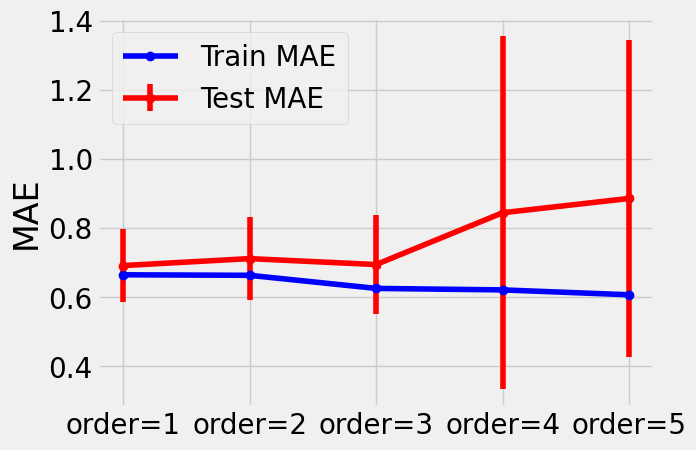

[0.6913126607944571,
 0.7114075415290892,
 0.6942324521278324,
 0.8441510741656219,
 0.8855266629173517]

In [25]:
def compare_polynomials(X, y, lr):
  train_errs = []
  test_errs = []
  stds = []
  labels = []
  for order in range(1,6):
    X_i = make_polynomial(X, order=order)
    train_errs.append(mae(lr.fit(X_i, y).predict(X_i), y))
    lr_i_mae, lr_i_std = cv_error(X_i, y, lr)
    test_errs.append(lr_i_mae)
    stds.append(lr_i_std)
    labels.append('order=%d' % order)
  return train_errs, test_errs, stds, labels


def plot_overfitting(train_errs, test_errs, stds, labels):
  plt.figure()
  xs = np.arange(len(test_errs))
  plt.errorbar(xs, test_errs, fmt='ro-', yerr=stds, label='Test MAE')
  plt.plot(xs, train_errs, 'bo-', label='Train MAE')
  plt.xticks(xs, labels)
  plt.ylabel('MAE')
  plt.legend(loc='upper left')
  plt.show()

train_errs, test_errs, stds, labels = compare_polynomials(X, y, lr)
plot_overfitting(train_errs, test_errs, stds, labels)
test_errs

(why does std increase with order??)

**So, which model should we choose here??**


<br><br><br>

This is a disappointing but not uncommon result -- we tried something more complex, and our generalization error did not improve.

A big part of machine learning is figuring out new methods that are complex but avoid overfitting.

A simple approach is called **L2-regularization**.
This adds a penalty term that encourages smaller parameter values.

$$\beta^* \leftarrow \text{argmin}_\beta ~~~ \text{RSS}(\beta, X, y) + \alpha \sum_k \beta_k^2$$

Here, the RSS error function from before is augmented with the sum of the squares of each parameter. The bigger the $\beta$s become, the higher our error.

The $\alpha$ parameter trades off the two terms in the objective --- we want to minimize RSS while minimizing weight magnitudes.

This approach is implemented in sklearn as [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

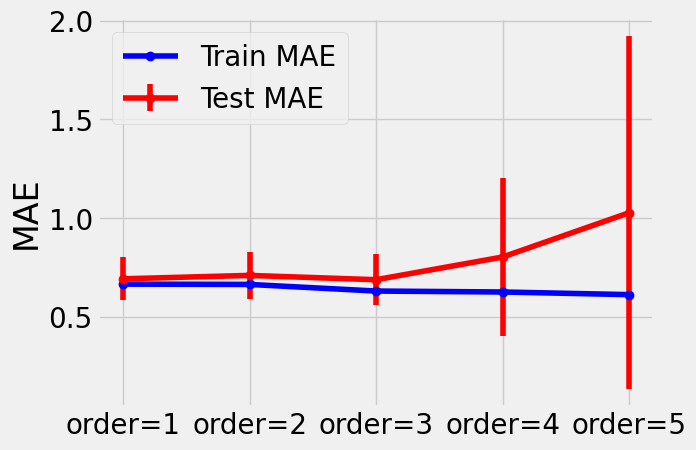

[0.6938645499843326,
 0.7111006460362693,
 0.6892980943520278,
 0.8041714648484503,
 1.0281814842115151]

In [26]:
from sklearn.linear_model import Ridge
train_errs, test_errs, stds, labels = compare_polynomials(X, y, Ridge(alpha=10))
plot_overfitting(train_errs, test_errs, stds, labels)
test_errs

We can get a slightly better error rate with Ridge. Though, the main advantage is that the variation in error is greatly reduced.